In [37]:
import os
import json
import errno
import zipfile
import pandas as pd

from shutil import rmtree

from zipfile import ZipFile
from tqdm import tqdm
from glob import iglob
from os.path import join as pjoin

In [38]:
def mkdir_p(path):
    try:
        os.makedirs(path)
    except OSError as exc:
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise
def del_folder(path):
    try:
        rmtree(path)
    except:
        pass

def read_json(json_path):
    with open(json_path, 'r') as f:
        return json.load(f)

def write_json(save_path, json_obj):
    with open(save_path, 'w', encoding='utf-8') as make_file:
        json.dump(json_obj, make_file, indent="\t")
    return

def get_extension(file_path):
    return file_path.split(".")[-1]


In [40]:
DATA_DIR = "/data/ai_hub"

In [41]:
ANNOT_DIR = pjoin(DATA_DIR, "annotations")
IMAGE_DIR = pjoin(DATA_DIR, "images")

In [42]:
emotion_kor_to_eng = {
    "기쁨" : "happy",
    "당황" : "embarrassing",
    "분노" : "angry",
    "불안" : "unrest",
    "상처" : "hurt",
    "슬픔" : "sad",
    "중립" : "neutral",
}

### **Load Images**

In [47]:
image_list = list(iglob(pjoin(IMAGE_DIR, "**/*.jpg")))

image_path = image_list[0]
emotion, image_name = image_path.split(os.sep)[-2:]
uid, gender, age, _, background, _ = image_name.split("_")


In [61]:
#-*-coding:utf-8 -*-
FEMALE_ID = '┐⌐'

image_list = list(iglob(pjoin(IMAGE_DIR, "**/*.jpg")))

data_rows = []
for image_path in tqdm(image_list, total=len(image_list), desc="Build image DataFrame"):
    emotion, image_name = image_path.split(os.sep)[-2:]

    image_name = image_name.split(".")[0]
    uid, sex, age, _, background, upload_id = image_name.split("_")
    row = {
        'uid': uid,
        'sex': 'female' if sex==FEMALE_ID else 'male',
        'age': age,
        'emotion': emotion,
        'upload_id': upload_id
    }
    data_rows += [row]

image_df = pd.DataFrame(data_rows, columns=['uid', 'sex', 'age', 'emotion', 'upload_id'])

Build image DataFrame: 100%|██████████| 427565/427565 [00:00<00:00, 542385.21it/s]


In [62]:
image_df.head()

,uid,sex,age,emotion,upload_id
0,a7ec0d470482eb7dad965c5239878a80351bfc545ab380...,female,30,angry,20210126165559-008-013
1,ca3a4e6e725cbd4765f642703c442507648cefb3eb9262...,female,20,angry,20201209133740-001-012
2,a667c053b3b14d27c1ee3b14dcf94851b3e5c7d5bc1c7e...,male,40,angry,20201206165753-002-025
3,39315cc47f869c05d22cdf3e07ad196c2266c0008e7f7c...,female,30,angry,20201207025953-010-016
4,c2391ae6ca010a33e9b40d5dc4416fc947deca98324f73...,female,30,angry,20210126172945-010-003


In [64]:
len(image_df)

427565

In [66]:
len(image_df.drop_duplicates())

427565

In [69]:
import pandas as pd
import numpy as np
import math
import torch
import re
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings

from os.path import join as pjoin

warnings.filterwarnings(action='ignore') 

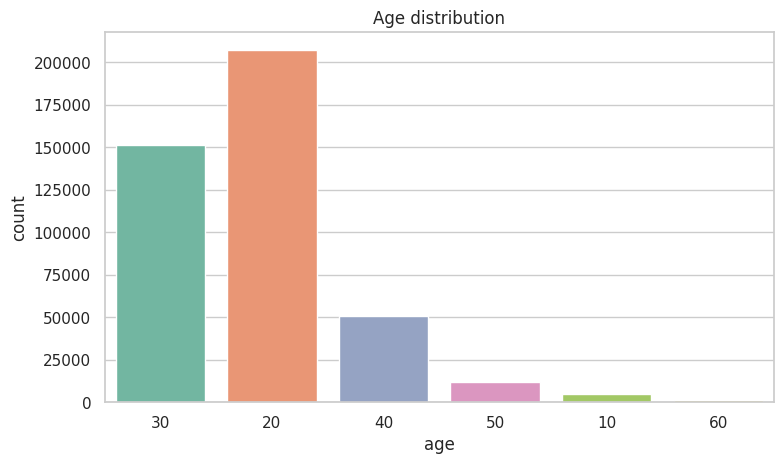

In [108]:
plt.rcParams["figure.figsize"] = (8, 5)
plt.rc('font', size=12)

fig, axarr = plt.subplots(1, 1)
sns.countplot(x=image_df["age"], ax=axarr, palette=sns.color_palette("Set2"))
axarr.set_title('Age distribution')

fig.tight_layout()
fig.subplots_adjust(top=0.88)

plt.show()

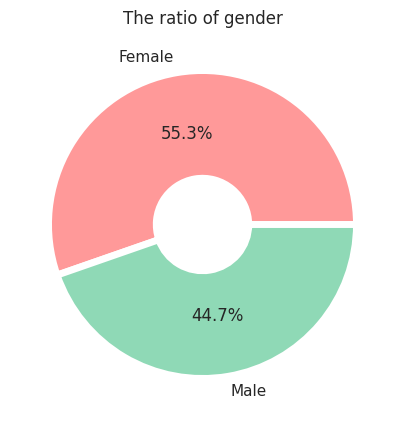

In [110]:
labels = ['Female', 'Male']
colors = ['#ff9999', '#8fd9b6']
wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}

plt.rcParams["figure.figsize"] = (5, 5)
plt.rc('font', size=12)

# entire_data = pd.concat([train_data, test_result])
female_ratio = len(image_df[image_df["sex"]=='female']) / len(image_df)
male_ratio = len(image_df[image_df["sex"]=='male']) / len(image_df)

ratios =[female_ratio, male_ratio]
plt.pie(ratios, labels=labels, autopct='%.1f%%', shadow=False, colors=colors, wedgeprops=wedgeprops)
plt.title('The ratio of gender')

plt.show()

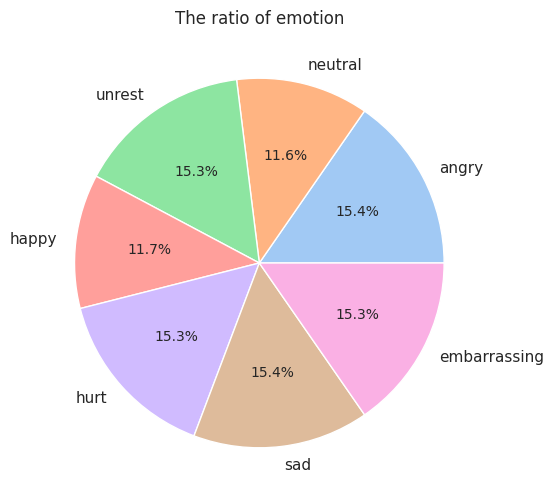

In [112]:
wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}
colors = sns.color_palette('pastel')[0:7]

plt.rcParams["figure.figsize"] = (6, 6)
plt.rc('font', size=10)

fig, axarr = plt.subplots(1, 1)

emotion_list = list(image_df['emotion'].unique())

ratios, labels = [], []
for emotion in emotion_list:
    ratio = len(image_df[image_df["emotion"] == emotion]) / len(image_df)
    ratios += [ratio]
    labels += [f'{emotion}']

axarr.pie(ratios, labels=labels, autopct='%.1f%%', shadow=False, colors = colors)
axarr.set_title('The ratio of emotion')

plt.show()

### **Generated dialogue dataset**

In [6]:
sample_val = pd.read_parquet(pjoin(DATA_DIR, "sample_val", "val_sample_1000.parquet"))
sample_val

,filename,age,sex,emotion,gpt_prompt,dialogue
0,8eda43d87e4ef16a231f97114c20d59660b02b99514db5...,30,male,angry,"On the screen, the face of a 30 year old male ...",Question: Are you feeling angry right now?\nAn...
1,60f9f06dcbf85639b594a076906a68377135895dea575e...,40,female,angry,"On the screen, the face of a 40 year old femal...",System: It seems like you're feeling angry rig...
2,93be3d09b7faa6b1ca4c6223cf9f3d0cb66ad91faf837f...,30,female,angry,"On the screen, the face of a 30 year old femal...",Question: Are you feeling angry or upset right...
3,534cd9fc1f57352eda6275c4e23a2a5781f9f253854a59...,20,male,angry,A 20-year-old male patient is in front of me t...,Question: Are you feeling angry right now?\nAn...
4,8b8f577b0f7a8fbfc56520b243dcc09ec7567b7db02f4e...,30,female,angry,A 30-year-old female patient is in front of me...,Question: Are you feeling angry right now?\nAn...
...,...,...,...,...,...,...
995,b5e7df0a903628cdb46ee2553b1ebce588bdab0e058876...,40,male,angry,A 40-year-old male patient is shown on the scr...,System: It seems like you're feeling angry. Is...
996,c0c96a02d14a1438184c7e3530f86a11eb9007713b940d...,50,female,angry,A 50-year-old female patient is shown on the s...,Question: Are you feeling angry right now?\nAn...
997,d489da5295a616e29b53e9c72af7d58f2c0ed7955cafe1...,20,male,angry,A 20-year-old male patient is shown on the scr...,System: You seem angry and upset. Is there som...
998,3b41262ea64af03434c6d5553470563bfd0ad8f26943fb...,40,male,angry,A 40-year-old male patient is in front of me t...,Question: Are you feeling angry right now?\nAn...


In [11]:
sample_val.iloc[0]['dialogue']

"Question: Are you feeling angry right now?\nAnswer: Yes, I'm feeling really angry.\nQuestion: What triggers your anger in this moment?\nAnswer: I feel overwhelmed and frustrated with my panic disorder symptoms.\nQuestion: How do you usually cope with your anger?\nAnswer: I try to remind myself to take deep breaths and practice relaxation techniques when I feel anger rising.\nQuestion: Have you noticed any specific symptoms during your panic attacks?\nAnswer: Yes, I often experience palpitations, shortness of breath, and a sense of derealization during my panic attacks.\nQuestion: How long do your panic attacks typically last?\nAnswer: They can last anywhere from a few minutes to an hour, but the intense symptoms usually subside after about 10-15 minutes."

In [10]:
print(sample_val.iloc[0]['dialogue'])

Question: Are you feeling angry right now?
Answer: Yes, I'm feeling really angry.
Question: What triggers your anger in this moment?
Answer: I feel overwhelmed and frustrated with my panic disorder symptoms.
Question: How do you usually cope with your anger?
Answer: I try to remind myself to take deep breaths and practice relaxation techniques when I feel anger rising.
Question: Have you noticed any specific symptoms during your panic attacks?
Answer: Yes, I often experience palpitations, shortness of breath, and a sense of derealization during my panic attacks.
Question: How long do your panic attacks typically last?
Answer: They can last anywhere from a few minutes to an hour, but the intense symptoms usually subside after about 10-15 minutes.


In [12]:
{'panic disorder symptoms' : None, 
 'user state': 'stable', 
 'panic triggering situation': None, 
 'active or not': 'not', 
 'frequency': None, 
 'severity level': None, 
 'countermeasure action': None}

{'panic disorder symptoms': None,
 'user state': 'stable',
 'panic triggering situation': None,
 'active or not': 'not',
 'frequency': None,
 'severity level': None,
 'countermeasure action': None}